# One-Hot Encoding


## Encoding flight origin
The org column in the flights data is a categorical variable giving the airport from which a flight departs.

- ORD — O'Hare International Airport (Chicago)
- SFO — San Francisco International Airport
- JFK — John F Kennedy International Airport (New York)
- LGA — La Guardia Airport (New York)
- SMF — Sacramento
- SJC — San Jose
- TUS — Tucson International Airport
- OGG — Kahului (Hawaii)

Obviously this is only a small subset of airports. Nevertheless, since this is a categorical variable, it needs to be one-hot encoded before it can be used in a regression model.

The data are in a variable called flights. You have already used a string indexer to create a column of indexed values corresponding to the strings in org.

Note:: You might find it useful to revise the slides from the lessons in the Slides panel next to the IPython Shell.

### init

In [1]:
import findspark
findspark.init()

import numpy as np
import pandas as pd
import pyspark
pyspark.__version__
# Import the PySpark module
from pyspark.sql import SparkSession
# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('test') \
                    .getOrCreate()

# What version of Spark?
print(spark.version)

2.4.5


In [6]:
#upload and download

from downloadfromFileIO import saveFromFileIO
""" à executer sur datacamp: (apres copie du code uploadfromdatacamp.py)
df_flights = flights.toPandas()
uploadToFileIO(df_flights)
"""

tobedownloaded="""
{pandas.core.frame.DataFrame: {'df_flights.csv': 'https://file.io/zm7yeJ'}}
"""
prefixToc = '1.1'
prefix = saveFromFileIO(tobedownloaded, prefixToc=prefixToc, proxy="10.225.92.1:80")


# Read data from CSV file
flights = spark.read.csv(prefix+'df_flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

flights=flights.drop('_c0')
# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)

flights = flights.withColumn("delay", flights.delay.cast('integer'))

# Check column data types
flights.dtypes

Téléchargements déjà effectués - SKIP
The data contain 50000 records.
+---+---+---+-------+------+---+----+------+--------+-----+-------+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|org_idx|
+---+---+---+-------+------+---+----+------+--------+-----+-------+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| null|    2.0|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82| 30.0|    0.0|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82| -8.0|    1.0|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195| -5.0|    0.0|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| null|    0.0|
+---+---+---+-------+------+---+----+------+--------+-----+-------+
only showing top 5 rows



[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('mile', 'int'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('org_idx', 'double')]

### code

In [8]:
# Import the one hot encoder class
from pyspark.ml.feature import OneHotEncoderEstimator

# Create an instance of the one hot encoder
onehot = OneHotEncoderEstimator(inputCols=['org_idx'], outputCols=['org_dummy'])

# Apply the one hot encoder to the flights data
onehot = onehot.fit(flights)
flights_onehot = onehot.transform(flights)

# Check the results
flights_onehot.select('org', 'org_idx', 'org_dummy').distinct().sort('org_idx').show()

+---+-------+-------------+
|org|org_idx|    org_dummy|
+---+-------+-------------+
|ORD|    0.0|(7,[0],[1.0])|
|SFO|    1.0|(7,[1],[1.0])|
|JFK|    2.0|(7,[2],[1.0])|
|LGA|    3.0|(7,[3],[1.0])|
|SJC|    4.0|(7,[4],[1.0])|
|SMF|    5.0|(7,[5],[1.0])|
|TUS|    6.0|(7,[6],[1.0])|
|OGG|    7.0|    (7,[],[])|
+---+-------+-------------+



## Encoding shirt sizes
You have data for a consignment of t-shirts. The data includes the size of the shirt, which is given as either S, M, L or XL.

Here are the counts for the different sizes:

+----+-----+
|size|count|
+----+-----+
|   S|    8|
|   M|   15|
|   L|   20|
|  XL|    7|
+----+-----+
The sizes are first converted to an index using StringIndexer and then one-hot encoded using OneHotEncoderEstimator.

Which of the following is not true:

# Regression

## Flight duration model: Just distance
In this exercise you'll build a regression model to predict flight duration (the duration column).

For the moment you'll keep the model simple, including only the distance of the flight (the km column) as a predictor.

The data are in flights. The first few records are displayed in the terminal. These data have also been split into training and testing sets and are available as flights_train and flights_test.

### init

In [11]:
#upload and download

from downloadfromFileIO import saveFromFileIO
""" à executer sur datacamp: (apres copie du code uploadfromdatacamp.py)
df_flights = flights.toPandas()
df_flights_train = flights_train.toPandas()
df_flights_test = flights_test.toPandas()
uploadToFileIO(df_flights, df_flights_train, df_flights_test)
"""

tobedownloaded="""
{pandas.core.frame.DataFrame: {'df_flights.csv': 'https://file.io/EVQEya',
  'df_flights_test.csv': 'https://file.io/k8CBKx',
  'df_flights_train.csv': 'https://file.io/qNQAx6'}}
"""
prefixToc = '2.1'
prefix = saveFromFileIO(tobedownloaded, prefixToc=prefixToc, proxy="10.225.92.1:80")


# Read data from CSV file
flights = spark.read.csv(prefix+'df_flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_train = spark.read.csv(prefix+'df_flights_train.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_test = spark.read.csv(prefix+'df_flights_test.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

flights=flights.drop('_c0')
flights_train=flights.drop('_c0')
flights_test=flights.drop('_c0')
# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)
flights_train.show(5)
flights_test.show(5)


flights = flights.withColumn("delay", flights.delay.cast('integer'))
flights_train = flights_train.withColumn("delay", flights_train.delay.cast('integer'))
flights_test = flights_test.withColumn("delay", flights_test.delay.cast('integer'))

# Check column data types
flights.dtypes

Téléchargements déjà effectués - SKIP
The data contain 5000 records.
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|    org_dummy|features|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------+
| 11| 20|  6|     US|    19|JFK|  9.48|     351| null|3465.0|    2.0|(7,[2],[1.0])|[3465.0]|
|  0| 22|  2|     UA|  1107|ORD| 16.33|      82| 30.0| 509.0|    0.0|(7,[0],[1.0])| [509.0]|
|  2| 20|  4|     UA|   226|SFO|  6.17|      82| -8.0| 542.0|    1.0|(7,[1],[1.0])| [542.0]|
|  9| 13|  1|     AA|   419|ORD| 10.33|     195| -5.0|1989.0|    0.0|(7,[0],[1.0])|[1989.0]|
|  4|  2|  5|     AA|   325|ORD|  8.92|      65| null| 415.0|    0.0|(7,[0],[1.0])| [415.0]|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------+
only showing top 5 rows

+---+---+---+-------+------+---+------+--------+-----+------+-------+

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('km', 'double'),
 ('org_idx', 'double'),
 ('org_dummy', 'string'),
 ('features', 'string')]

In [26]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

def turnToVector(dataset):
    # Repeat the process for the other categorical feature
    dataset_indexed = StringIndexer(inputCol='org', outputCol='org_idx2').fit(dataset).transform(dataset)
    dataset_indexed = dataset_indexed.drop('org_dummy', 'features')
    # Create a OneHotEncoder
    dataset_indexed = OneHotEncoder(inputCol='org_idx2', outputCol='org_dummy').transform(dataset_indexed)
    dataset = dataset_indexed.drop('org_idx2')
    # Create an assembler object
    assembler = VectorAssembler(inputCols=[
        'km'
    ], outputCol='features')
    # Consolidate predictor columns
    dataset = assembler.transform(dataset)
    return dataset

flights=turnToVector(flights)
flights_train=turnToVector(flights_train)
flights_test=turnToVector(flights_test)

### code

In [31]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# Create predictions for the testing data and take a look at the predictions
predictions = regression.transform(flights_test)
predictions.select('duration', 'prediction').show(5, False)

# Calculate the RMSE
RegressionEvaluator(labelCol='duration').evaluate(predictions)

+--------+------------------+
|duration|prediction        |
+--------+------------------+
|351     |306.10649257697014|
|82      |82.73496223315972 |
|82      |85.22862275458927 |
|195     |194.57185834575765|
|65      |75.63180802060282 |
+--------+------------------+
only showing top 5 rows



16.902282759734597

## Interpreting the coefficients
The linear regression model for flight duration as a function of distance takes the form

duration=α+β×distance
where

- α — intercept (component of duration which does not depend on distance) and
- β — coefficient (rate at which duration increases as a function of distance; also called the slope).

By looking at the coefficients of your model you will be able to infer

- how much of the average flight duration is actually spent on the ground and
- what the average speed is during a flight.

The linear regression model is available as regression.

### code

In [33]:
# Intercept (average minutes on ground)
inter = regression.intercept
print(inter)

# Coefficients
coefs = regression.coefficients
print(coefs)

# Average minutes per km
minutes_per_km = regression.coefficients[0]
print(minutes_per_km)

# Average speed in km per hour
avg_speed = 60 / minutes_per_km
print(avg_speed)

44.2721378268676
[0.07556547034634994]
0.07556547034634994
794.0134525067267


## Flight duration model: Adding origin airport
Some airports are busier than others. Some airports are bigger than others too. Flights departing from large or busy airports are likely to spend more time taxiing or waiting for their takeoff slot. So it stands to reason that the duration of a flight might depend not only on the distance being covered but also the airport from which the flight departs.

You are going to make the regression model a little more sophisticated by including the departure airport as a predictor.

These data have been split into training and testing sets and are available as flights_train and flights_test. The origin airport, stored in the org column, has been indexed into org_idx, which in turn has been one-hot encoded into org_dummy. The first few records are displayed in the terminal.


In [34]:
flights.show(
)

+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|    org_dummy|features|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------+
| 11| 20|  6|     US|    19|JFK|  9.48|     351| null|3465.0|    2.0|(7,[2],[1.0])|[3465.0]|
|  0| 22|  2|     UA|  1107|ORD| 16.33|      82|   30| 509.0|    0.0|(7,[0],[1.0])| [509.0]|
|  2| 20|  4|     UA|   226|SFO|  6.17|      82|   -8| 542.0|    1.0|(7,[1],[1.0])| [542.0]|
|  9| 13|  1|     AA|   419|ORD| 10.33|     195|   -5|1989.0|    0.0|(7,[0],[1.0])|[1989.0]|
|  4|  2|  5|     AA|   325|ORD|  8.92|      65| null| 415.0|    0.0|(7,[0],[1.0])| [415.0]|
|  5|  2|  1|     UA|   704|SFO|  7.98|     102|    2| 885.0|    1.0|(7,[1],[1.0])| [885.0]|
|  7|  2|  6|     AA|   380|ORD| 10.83|     135|   54|1180.0|    0.0|(7,[0],[1.0])|[1180.0]|
|  1| 16|  6|     UA|  1477|ORD|   8.0|     232|   -7|2317.0|    0.0|(

### init

In [51]:
#upload and download

from downloadfromFileIO import saveFromFileIO
""" à executer sur datacamp: (apres copie du code uploadfromdatacamp.py)
df_flights = flights.toPandas()
df_flights_train = flights_train.toPandas()
df_flights_test = flights_test.toPandas()
uploadToFileIO(df_flights, df_flights_train, df_flights_test)
"""

tobedownloaded="""
{pandas.core.frame.DataFrame: {'df_flights.csv': 'https://file.io/CEJm6A',
  'df_flights_test.csv': 'https://file.io/Fw6X72',
  'df_flights_train.csv': 'https://file.io/tSbDDp'}}
"""
prefixToc = '2.3'
prefix = saveFromFileIO(tobedownloaded, prefixToc=prefixToc, proxy="10.225.92.1:80")


# Read data from CSV file
flights = spark.read.csv(prefix+'df_flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_train = spark.read.csv(prefix+'df_flights_train.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_test = spark.read.csv(prefix+'df_flights_test.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

flights=flights.drop('_c0')
flights_train=flights.drop('_c0')
flights_test=flights.drop('_c0')
# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)
flights_train.show(5)
flights_test.show(5)


flights = flights.withColumn("delay", flights.delay.cast('integer'))
flights_train = flights_train.withColumn("delay", flights_train.delay.cast('integer'))
flights_test = flights_test.withColumn("delay", flights_test.delay.cast('integer'))

# Check column data types
flights.dtypes

Téléchargements déjà effectués - SKIP
The data contain 50000 records.
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|    org_dummy|            features|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------------------+
| 11| 20|  6|     US|    19|JFK|  9.48|     351| null|3465.0|    2.0|(7,[2],[1.0])|(8,[0,3],[3465.0,...|
|  0| 22|  2|     UA|  1107|ORD| 16.33|      82| 30.0| 509.0|    0.0|(7,[0],[1.0])|(8,[0,1],[509.0,1...|
|  2| 20|  4|     UA|   226|SFO|  6.17|      82| -8.0| 542.0|    1.0|(7,[1],[1.0])|(8,[0,2],[542.0,1...|
|  9| 13|  1|     AA|   419|ORD| 10.33|     195| -5.0|1989.0|    0.0|(7,[0],[1.0])|(8,[0,1],[1989.0,...|
|  4|  2|  5|     AA|   325|ORD|  8.92|      65| null| 415.0|    0.0|(7,[0],[1.0])|(8,[0,1],[415.0,1...|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('km', 'double'),
 ('org_idx', 'double'),
 ('org_dummy', 'string'),
 ('features', 'string')]

In [67]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

def turnOrgKMToVector(dataset):
    # Repeat the process for the other categorical feature
    dataset_indexed = StringIndexer(inputCol='org', outputCol='org_idx2').fit(dataset).transform(dataset)
    dataset_indexed = dataset_indexed.drop('org_dummy', 'features')
    # Create a OneHotEncoder
    dataset_indexed = OneHotEncoder(inputCol='org_idx2', outputCol='org_dummy').transform(dataset_indexed)
    dataset = dataset_indexed.drop('org_idx2')
    # Create an assembler object
    assembler = VectorAssembler(inputCols=['km','org_dummy'], outputCol='features')
    dataset = assembler.transform(dataset)
    return dataset

# Create an assembler object
flights=turnOrgKMToVector(flights)
flights_train=turnOrgKMToVector(flights_train)
flights_test=turnOrgKMToVector(flights_test)

In [68]:
flights.dtypes

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('km', 'double'),
 ('org_idx', 'double'),
 ('org_dummy', 'vector'),
 ('features', 'vector')]

In [70]:
flights.show()

+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|    org_dummy|            features|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+--------------------+
| 11| 20|  6|     US|    19|JFK|  9.48|     351| null|3465.0|    2.0|(7,[2],[1.0])|(8,[0,3],[3465.0,...|
|  0| 22|  2|     UA|  1107|ORD| 16.33|      82|   30| 509.0|    0.0|(7,[0],[1.0])|(8,[0,1],[509.0,1...|
|  2| 20|  4|     UA|   226|SFO|  6.17|      82|   -8| 542.0|    1.0|(7,[1],[1.0])|(8,[0,2],[542.0,1...|
|  9| 13|  1|     AA|   419|ORD| 10.33|     195|   -5|1989.0|    0.0|(7,[0],[1.0])|(8,[0,1],[1989.0,...|
|  4|  2|  5|     AA|   325|ORD|  8.92|      65| null| 415.0|    0.0|(7,[0],[1.0])|(8,[0,1],[415.0,1...|
|  5|  2|  1|     UA|   704|SFO|  7.98|     102|    2| 885.0|    1.0|(7,[1],[1.0])|(8,[0,2],[885.0,1...|
|  7|  2|  6|     AA|   380|ORD| 10.83|     135|   54|1

### code

In [72]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# Create predictions for the testing data
predictions = regression.transform(flights_test)

# Calculate the RMSE on testing data
RegressionEvaluator(labelCol='duration').evaluate(predictions)

11.21944622452595

## Interpreting coefficients
Remember that origin airport, org, has eight possible values (ORD, SFO, JFK, LGA, SMF, SJC, TUS and OGG) which have been one-hot encoded to seven dummy variables in org_dummy.

The values for km and org_dummy have been assembled into features, which has eight columns with sparse representation. Column indices in features are as follows:

- 0 — km
- 1 — ORD
- 2 — SFO
- 3 — JFK
- 4 — LGA
- 5 — SMF
- 6 — SJC and
- 7 — TUS.

Note that OGG does not appear in this list because it is the reference level for the origin airport category.

In this exercise you'll be using the intercept and coefficients attributes to interpret the model.

The coefficients attribute is a list, where the first element indicates how flight duration changes with flight distance.

### code

In [74]:
# Average speed in km per hour
avg_speed_hour = 60 / regression.coefficients[0]
print(avg_speed_hour)

# Average minutes on ground at OGG
inter = regression.intercept
print(inter)

# Average minutes on ground at JFK
avg_ground_jfk = inter + regression.coefficients[3]
print(avg_ground_jfk)

# Average minutes on ground at LGA
avg_ground_lga = inter + regression.coefficients[4]
print(avg_ground_lga)

807.4988664780973
15.80534727457103
68.46505505231659
62.56759800083867


# Bucketing & Engineering


## Bucketing departure time
Time of day data are a challenge with regression models. They are also a great candidate for bucketing.

In this lesson you will convert the flight departure times from numeric values between 0 (corresponding to 00:00) and 24 (corresponding to 24:00) to binned values. You'll then take those binned values and one-hot encode them.


### init

In [75]:
prefix = 'data_from_datacamp/chapter1-Exercise3.1_'
# Read data from CSV file
flights = spark.read.csv(prefix+'flights.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

# Get number of records
print("The data contain %d records." % flights.count())

# View the first five records
flights.show(5)

# Check column data types
flights.dtypes

The data contain 50000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 11| 20|  6|     US|    19|JFK|2153|  9.48|     351| null|
|  0| 22|  2|     UA|  1107|ORD| 316| 16.33|      82|   30|
|  2| 20|  4|     UA|   226|SFO| 337|  6.17|      82|   -8|
|  9| 13|  1|     AA|   419|ORD|1236| 10.33|     195|   -5|
|  4|  2|  5|     AA|   325|ORD| 258|  8.92|      65| null|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('mile', 'int'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int')]

### code

In [78]:
from pyspark.ml.feature import Bucketizer, OneHotEncoderEstimator

# Create buckets at 3 hour intervals through the day
buckets = Bucketizer(splits=[0,3,6,9,12,15,18,21,24], inputCol='depart', outputCol='depart_bucket')

# Bucket the departure times
bucketed = buckets.transform(flights)
bucketed.select('depart', 'depart_bucket').show(5)

# Create a one-hot encoder
onehot = OneHotEncoderEstimator(inputCols=['depart_bucket'], outputCols=['depart_dummy'])

# One-hot encode the bucketed departure times
flights_onehot = onehot.fit(bucketed).transform(bucketed)
flights_onehot.select('depart', 'depart_bucket', 'depart_dummy').show(5)

+------+-------------+
|depart|depart_bucket|
+------+-------------+
|  9.48|          3.0|
| 16.33|          5.0|
|  6.17|          2.0|
| 10.33|          3.0|
|  8.92|          2.0|
+------+-------------+
only showing top 5 rows

+------+-------------+-------------+
|depart|depart_bucket| depart_dummy|
+------+-------------+-------------+
|  9.48|          3.0|(7,[3],[1.0])|
| 16.33|          5.0|(7,[5],[1.0])|
|  6.17|          2.0|(7,[2],[1.0])|
| 10.33|          3.0|(7,[3],[1.0])|
|  8.92|          2.0|(7,[2],[1.0])|
+------+-------------+-------------+
only showing top 5 rows



## Flight duration model: Adding departure time
In the previous exercise the departure time was bucketed and converted to dummy variables. Now you're going to include those dummy variables in a regression model for flight duration.

The data are in flights. The km, org_dummy and depart_dummy columns have been assembled into features, where km is index 0, org_dummy runs from index 1 to 7 and depart_dummy from index 8 to 14.

The data have been split into training and testing sets and a linear regression model, regression, has been built on the training data. Predictions have been made on the testing data and are available as predictions.
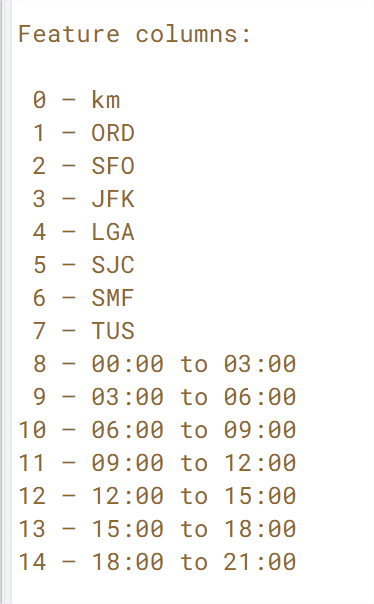

### init

In [85]:
#upload and download

from downloadfromFileIO import saveFromFileIO
""" à executer sur datacamp: (apres copie du code uploadfromdatacamp.py)
df_predictions = predictions.toPandas()
df_flights_train = flights_train.toPandas()
df_flights_test = flights_test.toPandas()
uploadToFileIO(df_predictions, df_flights_train, df_flights_test)
"""

tobedownloaded="""
{pandas.core.frame.DataFrame: {'df_flights_test.csv': 'https://file.io/7hLGqq',
  'df_flights_train.csv': 'https://file.io/ICJOgb',
  'df_predictions.csv': 'https://file.io/JqLtv5'}}
"""
prefixToc = '3.2'
prefix = saveFromFileIO(tobedownloaded, prefixToc=prefixToc, proxy="10.225.92.1:80")


# Read data from CSV file
predictions = spark.read.csv(prefix+'df_predictions.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_train = spark.read.csv(prefix+'df_flights_train.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_test = spark.read.csv(prefix+'df_flights_test.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

predictions=predictions.drop('_c0')
flights_train=flights_train.drop('_c0')
flights_test=flights_test.drop('_c0')
# Get number of records
print("The data predictions contain %d records." % predictions.count())
print("The data flights_train contain %d records." % flights_train.count())
print("The data flights_test contain %d records." % flights_test.count())

# View the first five records
predictions.show(5)
flights_train.show(5)
flights_test.show(5)


predictions = predictions.withColumn("delay", predictions.delay.cast('integer'))
flights_train = flights_train.withColumn("delay", flights_train.delay.cast('integer'))
flights_test = flights_test.withColumn("delay", flights_test.delay.cast('integer'))

# Check column data types
predictions.dtypes

Téléchargements déjà effectués - SKIP
The data predictions contain 10075 records.
The data flights_train contain 39925 records.
The data flights_test contain 10075 records.
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------------+-------------+--------------------+------------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|    org_dummy|depart_bucket| depart_dummy|            features|        prediction|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------------+-------------+--------------------+------------------+
|  0|  1|  2|     AA|    59|JFK|   7.0|     385|-16.0|4162.0|    2.0|(7,[2],[1.0])|          2.0|(7,[2],[1.0])|(15,[0,3,10],[416...|376.00910524773906|
|  0|  1|  2|     AA|   154|ORD| 17.25|     135| 49.0|1395.0|    0.0|(7,[0],[1.0])|          5.0|(7,[5],[1.0])|(15,[0,1,13],[139...|150.23944305794492|
|  0|  1|  2|     AA|   502|SJC| 17.58|     200| 66.0|2375.0|    4.

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('km', 'double'),
 ('org_idx', 'double'),
 ('org_dummy', 'string'),
 ('depart_bucket', 'double'),
 ('depart_dummy', 'string'),
 ('features', 'string'),
 ('prediction', 'double')]

In [93]:
def transformToVector(dataset):
    # Create a one-hot encoder
    dataset = dataset.drop('depart_dummy', 'org_dummy', 'features')

    # Create instances of one hot encoders
    onehot_depart = OneHotEncoderEstimator(inputCols=['depart_bucket'], outputCols=['depart_dummy'])
    onehot_org = OneHotEncoderEstimator(inputCols=['org_idx'], outputCols=['org_dummy'])

    # One-hot encode the bucketed departure times
    dataset = onehot_depart.fit(dataset).transform(dataset)
    # One-hot encode the org
    dataset = onehot_org.fit(dataset).transform(dataset)
    
    assembler = VectorAssembler(inputCols=['km','org_dummy', 'depart_dummy'], outputCol='features')
    dataset = assembler.transform(dataset)
    return dataset

predictions = transformToVector(predictions)
flights_train = transformToVector(flights_train)
flights_test = transformToVector(flights_test)

In [94]:
predictions.show(2)



+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+------------------+-------------+-------------+--------------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|depart_bucket|        prediction| depart_dummy|    org_dummy|            features|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+------------------+-------------+-------------+--------------------+
|  0|  1|  2|     AA|    59|JFK|   7.0|     385|  -16|4162.0|    2.0|          2.0|376.00910524773906|(7,[2],[1.0])|(7,[2],[1.0])|(15,[0,3,10],[416...|
|  0|  1|  2|     AA|   154|ORD| 17.25|     135|   49|1395.0|    0.0|          5.0|150.23944305794492|(7,[5],[1.0])|(7,[0],[1.0])|(15,[0,1,13],[139...|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+------------------+-------------+-------------+--------------------+
only showing top 2 rows



In [95]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Create a regression object and train on training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# Create predictions for the testing data
predictions2 = regression.transform(flights_test)

In [96]:
predictions2.show(2)

+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------------+-------------+--------------------+------------------+
|mon|dom|dow|carrier|flight|org|depart|duration|delay|    km|org_idx|depart_bucket| depart_dummy|    org_dummy|            features|        prediction|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------------+-------------+--------------------+------------------+
|  0|  1|  2|     AA|    59|JFK|   7.0|     385|  -16|4162.0|    2.0|          2.0|(7,[2],[1.0])|(7,[2],[1.0])|(15,[0,3,10],[416...|376.00910524773906|
|  0|  1|  2|     AA|   154|ORD| 17.25|     135|   49|1395.0|    0.0|          5.0|(7,[5],[1.0])|(7,[0],[1.0])|(15,[0,1,13],[139...|150.23944305794492|
+---+---+---+-------+------+---+------+--------+-----+------+-------+-------------+-------------+-------------+--------------------+------------------+
only showing top 2 rows



### code

In [97]:
# Find the RMSE on testing data
from pyspark.ml.evaluation import RegressionEvaluator
RegressionEvaluator(labelCol='duration').evaluate(predictions)

# Average minutes on ground at OGG for flights departing between 21:00 and 24:00
avg_eve_ogg = regression.intercept
print(avg_eve_ogg)

# Average minutes on ground at OGG for flights departing between 00:00 and 03:00
avg_night_ogg = regression.intercept + regression.coefficients[8]
print(avg_night_ogg)

# Average minutes on ground at JFK for flights departing between 00:00 and 03:00
avg_night_jfk = regression.intercept + regression.coefficients[3] + regression.coefficients[8]
print(avg_night_jfk)

10.475615792093903
-4.125122945654926
47.580713975630594


# Regularization

## Flight duration model: More features!
Let's add more features to our model. This will not necessarily result in a better model. Adding some features might improve the model. Adding other features might make it worse.

More features will always make the model more complicated and difficult to interpret.

These are the features you'll include in the next model:

- km
- org (origin airport, one-hot encoded, 8 levels)
- depart (departure time, binned in 3 hour intervals, one-hot encoded, 8 levels)
- dow (departure day of week, one-hot encoded, 7 levels) and
- mon (departure month, one-hot encoded, 12 levels).

These have been assembled into the features column, which is a sparse representation of 32 columns (remember one-hot encoding produces a number of columns which is one fewer than the number of levels).

The data are available as flights, randomly split into flights_train and flights_test. The object predictions is also available.

### init

In [98]:
#upload and download

from downloadfromFileIO import saveFromFileIO
""" à executer sur datacamp: (apres copie du code uploadfromdatacamp.py)
df_predictions = predictions.toPandas()
df_flights_train = flights_train.toPandas()
df_flights_test = flights_test.toPandas()
uploadToFileIO(df_predictions, df_flights_train, df_flights_test)
"""

tobedownloaded="""
{pandas.core.frame.DataFrame: {'df_flights_test.csv': 'https://file.io/z8Wz1a',
  'df_flights_train.csv': 'https://file.io/USXK5j',
  'df_predictions.csv': 'https://file.io/XzrTZy'}}
"""
prefixToc = '4.1'
prefix = saveFromFileIO(tobedownloaded, prefixToc=prefixToc, proxy="10.225.92.1:80")


# Read data from CSV file
predictions = spark.read.csv(prefix+'df_predictions.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_train = spark.read.csv(prefix+'df_flights_train.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')
flights_test = spark.read.csv(prefix+'df_flights_test.csv',
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

predictions=predictions.drop('_c0')
flights_train=flights_train.drop('_c0')
flights_test=flights_test.drop('_c0')
# Get number of records
print("The data predictions contain %d records." % predictions.count())
print("The data flights_train contain %d records." % flights_train.count())
print("The data flights_test contain %d records." % flights_test.count())

# View the first five records
predictions.show(5)
flights_train.show(5)
flights_test.show(5)


predictions = predictions.withColumn("delay", predictions.delay.cast('integer'))
flights_train = flights_train.withColumn("delay", flights_train.delay.cast('integer'))
flights_test = flights_test.withColumn("delay", flights_test.delay.cast('integer'))

# Check column data types
predictions.dtypes

Téléchargements à lancer
{'pandas.core.frame.DataFrame': {'df_flights_test.csv': 'https://file.io/z8Wz1a', 'df_flights_train.csv': 'https://file.io/USXK5j', 'df_predictions.csv': 'https://file.io/XzrTZy'}}
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31131    0 31131    0     0  22188      0 --:--:--  0:00:01 --:--:-- 22188

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124k    0  124k    0     0  44861      0 --:--:--  0:00:02 --:--:-- 44861

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25860    0 25860    0     0  83419      0 --:--:-- --:--:-- --:--:-- 83689

The data predictions contain 195 records.
The data flights_train contain 805 rec

[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'int'),
 ('km', 'double'),
 ('org_idx', 'double'),
 ('org_dummy', 'string'),
 ('depart_bucket', 'double'),
 ('depart_dummy', 'string'),
 ('features', 'string'),
 ('prediction', 'double')]

In [104]:
def transformToVector(dataset):
    # Create a one-hot encoder
    dataset = dataset.drop('depart_dummy', 'org_dummy', 'features', 'dow_dummy', 'mon_dummy')

    # Create instances of one hot encoders
    onehot_depart = OneHotEncoderEstimator(inputCols=['depart_bucket'], outputCols=['depart_dummy'])
    onehot_org = OneHotEncoderEstimator(inputCols=['org_idx'], outputCols=['org_dummy'])
    onehot_dow = OneHotEncoderEstimator(inputCols=['dow'], outputCols=['dow_dummy'])
    onehot_mon = OneHotEncoderEstimator(inputCols=['mon'], outputCols=['mon_dummy'])

    # One-hot encode the bucketed departure times
    dataset = onehot_depart.fit(dataset).transform(dataset)
    # One-hot encode the org
    dataset = onehot_org.fit(dataset).transform(dataset)
    dataset = onehot_dow.fit(dataset).transform(dataset)
    dataset = onehot_mon.fit(dataset).transform(dataset)
    
    assembler = VectorAssembler(inputCols=['km','org_dummy', 'depart_dummy', 'dow_dummy', 'mon_dummy'], outputCol='features')
    dataset = assembler.transform(dataset)
    dataset = dataset.drop('dow_dummy', 'mon_dummy')
    return dataset

predictions = transformToVector(predictions)
flights_train = transformToVector(flights_train)
flights_test = transformToVector(flights_test)

In [106]:
flights_test.select('features','duration').show(5, False)

+--------------------------------------------+--------+
|features                                    |duration|
+--------------------------------------------+--------+
|(32,[0,3,14,17,21],[1728.0,1.0,1.0,1.0,1.0])|204     |
|(32,[0,1,10,18,21],[2773.0,1.0,1.0,1.0,1.0])|265     |
|(32,[0,6,14,21],[621.0,1.0,1.0,1.0])        |80      |
|(32,[0,4,13,16,21],[1180.0,1.0,1.0,1.0,1.0])|158     |
|(32,[0,5,13,17,21],[138.0,1.0,1.0,1.0,1.0]) |45      |
+--------------------------------------------+--------+
only showing top 5 rows



### code

In [107]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Fit linear regression model to training data
regression = LinearRegression(labelCol='duration').fit(flights_train)

# Make predictions on testing data
predictions = regression.transform(flights_test)

# Calculate the RMSE on testing data
rmse = RegressionEvaluator(labelCol='duration').evaluate(predictions)
print("The test RMSE is", rmse)

# Look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

The test RMSE is 9.932871937636765
[0.07466666934355301,8.078881563529334,1.9653119764127,30.90058109033576,25.975255321620892,-4.673220904608639,-0.5071146737729627,-19.35458238364859,-20.553418861596572,-1.5250162109404266,2.902212223024328,6.9230292833642215,4.830665365251793,7.567402763210368,6.7482370748914215,0.5888385584814597,0.9652580580230514,-0.5645623742771357,-0.6200119406154614,-1.2240717932722625,-1.3845856065896651,-4.574194011951068,-6.482639010679108,-3.8632479519852603,-3.7540130731837587,-8.8096609834927,-6.500070642930037,-5.396616986276698,-5.1580203920599885,-9.682260059912322,-5.6441219946379695,-5.467775936528763]


## Flight duration model: Regularisation!
In the previous exercise you added more predictors to the flight duration model. The model performed well on testing data, but with so many coefficients it was difficult to interpret.

In this exercise you'll use Lasso regression (regularized with a L1 penalty) to create a more parsimonious model. Many of the coefficients in the resulting model will be set to zero. This means that only a subset of the predictors actually contribute to the model. Despite the simpler model, it still produces a good RMSE on the testing data.

You'll use a specific value for the regularization strength. Later you'll learn how to find the best value using cross validation.

The data (same as previous exercise) are available as flights, randomly split into flights_train and flights_test.

### code

In [110]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Fit Lasso model (α = 1) to training data
regression = LinearRegression(labelCol='duration', regParam=1, elasticNetParam=1).fit(flights_train)

# Calculate the RMSE on testing data
rmse = RegressionEvaluator(labelCol='duration').evaluate(regression.transform(flights_test))
print("The test RMSE is", rmse)

# Look at the model coefficients
coeffs = regression.coefficients
print(coeffs)

# Number of zero coefficients
zero_coeff = sum([beta==0 for beta in regression.coefficients])
print("Number of ceofficients equal to 0:", zero_coeff)

The test RMSE is 10.984343771570359
[0.07389402740392768,2.291440243753814,-0.8760381259475464,23.86049085966021,17.50514370588225,-6.393301619531375,-1.491688863088528,-18.580714413668534,0.0,0.0,-0.2458206429833692,0.0,0.0,0.14127986333000958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.1202706248270329,0.0,0.0,0.0,0.0,0.0,0.0]
Number of ceofficients equal to 0: 21
